In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Install dependencies
!pip install -U torch torchvision
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-biuapjnu
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-biuapjnu
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=375547 sha256=5b768ecf132

In [6]:
# Install detectron2
!pip install git+https://github.com/facebookresearch/detectron2.git

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ywcek0g_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ywcek0g_
  Resolved https://github.com/facebookresearch/detectron2.git to commit 864913f0e57e87a75c8cc0c7d79ecbd774fc669b
  Preparing metadata (setup.py) ... done
  Using cached pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (426 kB)
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [7]:
# Verify Detectron2 installation
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("Detectron2 successfully installed!")

Detectron2 successfully installed!


In [9]:
# Some basic setup:
# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer

In [ ]:
#@title Select YOLOv8 🚀 logger {run: 'auto'}
logger = 'TensorBoard' #@param ['Comet', 'TensorBoard']

if logger == 'Comet':
  %pip install -q comet_ml
  import comet_ml; comet_ml.init()
elif logger == 'TensorBoard':
  %load_ext tensorboard
  %tensorboard --logdir .

<IPython.core.display.Javascript object>

In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
comet_ml.init(project_name="Detectron2_wheat_disease_OD")

In [10]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# Unregister all datasets
DatasetCatalog.clear()
MetadataCatalog.clear()

In [11]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog

train_image_path = "/content/drive/MyDrive/dissertation_project/wheat_dataset/wheat_dataset_640x640/images/train"
train_json_path = "/content/drive/MyDrive/dissertation_project/wheat_dataset/wheat_dataset_640x640/train.json"
test_image_path = "/content/drive/MyDrive/dissertation_project/wheat_dataset/wheat_dataset_640x640/images/test"
test_json_path = "/content/drive/MyDrive/dissertation_project/wheat_dataset/wheat_dataset_640x640/test.json"
val_image_path = "/content/drive/MyDrive/dissertation_project/wheat_dataset/wheat_dataset_640x640/images/validation"
val_json_path = "/content/drive/MyDrive/dissertation_project/wheat_dataset/wheat_dataset_640x640/validation.json"

register_coco_instances(
    "wheat_train",
     {},
    train_json_path,
    train_image_path)
MetadataCatalog.get("wheat_train").set(thing_classes=["wheat_brown_rust", "wheat_septoria", "wheat_mildew"])

register_coco_instances(
    "wheat_val",
     {},
    val_json_path,
    val_image_path)
MetadataCatalog.get("wheat_val").set(thing_classes=["wheat_brown_rust", "wheat_septoria", "wheat_mildew"])

register_coco_instances(
    "wheat_test",
     {},
    test_json_path,
    test_image_path)
MetadataCatalog.get("wheat_test").set(thing_classes=["wheat_brown_rust", "wheat_septoria", "wheat_mildew"])

namespace(name='wheat_test',
          json_file='/content/drive/MyDrive/dissertation_project/wheat_dataset/wheat_dataset_640x640/test.json',
          image_root='/content/drive/MyDrive/dissertation_project/wheat_dataset/wheat_dataset_640x640/images/test',
          evaluator_type='coco',
          thing_classes=['wheat_brown_rust', 'wheat_septoria', 'wheat_mildew'])

In [12]:
from detectron2.config import get_cfg
from detectron2.data import build_detection_train_loader
from detectron2.data.transforms import RandomFlip, RandomBrightness, RandomContrast, RandomRotation
from detectron2.data.transforms import RandomRotation, ResizeShortestEdge
from detectron2.data.transforms import RandomCrop

cfg = get_cfg()
#cfg.merge_from_file("/content/drive/MyDrive/dissertation_project/wheat_dataset/wheat_dataset_640x640/config_RCNN_FPN_detectron2.yaml")
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("wheat_train",)
cfg.DATASETS.TEST = ("wheat_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [0.25, 0.75, 1.5, 2.0, 3.5, 2.5]
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8  # This is the real "batch size" commonly known to deep learning people

cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.GAMMA = 0.005
cfg.SOLVER.STEPS = []

cfg.SOLVER.MAX_ITER = 4000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
#cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 640
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set the testing threshold for this model
# Add augmentations to the train dataset

cfg.INPUT.AUG = [
    RandomFlip(horizontal=True),
    RandomBrightness(0.5, 1.8),
    RandomContrast(0.5, 1.8),
    RandomRotation(angle=[-40, 40]),
]
#cfg.INPUT.AUG.append(RandomShear(0.2))  # Randomly apply shear transformation
#cfg.INPUT.AUG.append(RandomBlur())  # Randomly apply blur

In [ ]:
import wandb
wandb_api = "d6a41cf2af4d30e349e2ab58712a550a2cc9e8bc"
wandb.login(key=wandb_api)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader, build_detection_train_loader

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Set up Trainer
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# Start training
trainer.train()

# Add COCOEvaluator for validation
val_loader = build_detection_test_loader(cfg, "wheat_val")
evaluator = COCOEvaluator("wheat_val", cfg, False, output_dir="./output/")
val_metrics = inference_on_dataset(trainer.model, val_loader, evaluator)

[01/22 09:50:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[01/22 09:50:19 d2.engine.train_loop]: Starting training from iteration 0
[01/22 09:50:55 d2.utils.events]:  eta: 1:44:43  iter: 19  total_loss: 1.616  loss_cls: 0.853  loss_box_reg: 0.0009814  loss_rpn_cls: 0.6534  loss_rpn_loc: 0.09526    time: 1.5951  last_time: 1.6924  data_time: 0.4226  last_data_time: 0.2735   lr: 4.9953e-06  max_mem: 7284M
[01/22 09:51:27 d2.utils.events]:  eta: 1:43:57  iter: 39  total_loss: 1.343  loss_cls: 0.585  loss_box_reg: 0.0008535  loss_rpn_cls: 0.6397  loss_rpn_loc: 0.09555    time: 1.5900  last_time: 1.6979  data_time: 0.2312  last_data_time: 0.2929   lr: 9.9902e-06  max_mem: 7284M
[01/22 09:51:59 d2.utils.events]:  eta: 1:43:02  iter: 59  total_loss: 1.018  loss_cls: 0.2873  loss_box_reg: 0.002558  loss_rpn_cls: 0.6089  loss_rpn_loc: 0.09846    time: 1.5866  last_time: 1.7134  data_time: 0.2112  last_data_time: 0.2860   lr: 1.4985e-05  max_mem: 7284M
[01/22 09:52:34 d2.utils.events]:  eta: 1:43:14  iter: 79  total_loss: 0.8644  loss_cls: 0.1975  loss

In [14]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir=/content/drive/MyDrive/dissertation_project/model_training/output_new/events.out.tfevents.1705917055.e419a8d8c74b.5300.1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

In [15]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = ("/content/drive/MyDrive/dissertation_project/model_training/output_new/model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

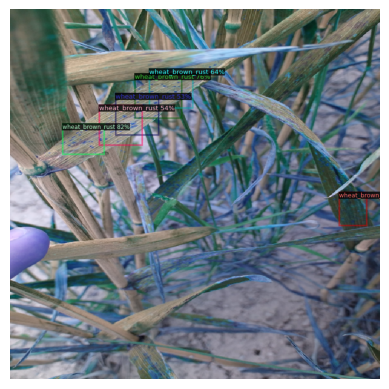

In [ ]:
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt

# Load an image for inference
image_path = "/content/drive/MyDrive/dissertation_project/wheat_dataset/wheat_dataset_640x640/images/test/Brust1302.png"  # Specify the path to your test image
im = cv2.imread(image_path)

# Perform inference
outputs = predictor(im)

# Visualize the result
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("wheat_test", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "wheat_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[01/22 11:46:45 d2.data.datasets.coco]: Loaded 63 images in COCO format from /content/drive/MyDrive/dissertation_project/wheat_dataset/wheat_dataset_640x640/test.json
[01/22 11:46:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/22 11:46:45 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/22 11:46:45 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[01/22 11:46:45 d2.data.common]: Serialized dataset takes 0.04 MiB
[01/22 11:46:45 d2.evaluation.evaluator]: Start inference on 63 batches
[01/22 11:46:46 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0015 s/iter. Inference: 0.0813 s/iter. Eval: 0.0003 s/iter. Total: 0.0830 s/iter. ETA=0:00:04
[01/22 11:46:50 d2.evaluation.evaluator]: Total inference time: 0:00:04.978651 (0.085839 s / iter per device, on 1 devic

In [ ]:
import os
import shutil
import torch

output_drive_path = '/content/drive/MyDrive/dissertation_project/model_training'

# Save the trained model to Google Drive
model_path = os.path.join(output_drive_path, 'model.pth')

# Save the entire model state (including architecture and weights)
torch.save(trainer.model.state_dict(), model_path)

# Copy the entire output directory to Google Drive
shutil.copytree('/content/output', os.path.join(output_drive_path, 'output_new'))

'/content/drive/MyDrive/dissertation_project/model_training/output_new'

# **Requirements**

In [ ]:
'''import os
import json
import xml.etree.ElementTree as ET

def xml_to_coco(xml_dir, image_dir):
    coco_annotation = {
        "images": [],
        "annotations": [],
        "categories": [],
    }

    category_id_map = {
        "wheat_septoria": 1,
        "wheat_brown_rust": 2,
        "wheat_mildew": 3
    }

    # Loop through all XML files in the directory
    for xml_file in os.listdir(xml_dir):
        if xml_file.endswith(".xml"):
            xml_path = os.path.join(xml_dir, xml_file)

            tree = ET.parse(xml_path)
            root = tree.getroot()

            # Unique identifier for the image
            image_id = os.path.splitext(os.path.basename(root.find("filename").text))[0]

            # Iterate through all objects in the XML file
            for obj in root.findall("object"):
                category = obj.find("name").text

                # Map category names to category IDs
                category_id = category_id_map[category]

                bbox = obj.find("bndbox")

                bbox_coords = [
                    float(bbox.find("xmin").text),
                    float(bbox.find("ymin").text),
                    float(bbox.find("xmax").text) - float(bbox.find("xmin").text),
                    float(bbox.find("ymax").text) - float(bbox.find("ymin").text),
                ]

                image_info = {
                    "id": image_id,
                    "width": int(root.find("size/width").text),
                    "height": int(root.find("size/height").text),
                    "file_name": os.path.join(image_dir, root.find("filename").text),
                }

                annotation_info = {
                    "id": len(coco_annotation["annotations"]) + 1,
                    "image_id": image_id,
                    "category_id": category_id,
                    "bbox": bbox_coords,
                    "area": bbox_coords[2] * bbox_coords[3],
                    "iscrowd": 0,
                    "segmentation": [],
                }

                coco_annotation["images"].append(image_info)
                coco_annotation["annotations"].append(annotation_info)

            # Add categories to the category list
            for category, category_id in category_id_map.items():
                if category_id not in coco_annotation["categories"]:
                    coco_annotation["categories"].append({"id": category_id, "name": category, "supercategory": "object"})

    return coco_annotation

# Example usage for a directory containing multiple XML files
xml_dir = "/content/drive/MyDrive/dissertation_project/wheat_dataset/wheat_dataset_640x640/annotations/validation"
image_dir = "/content/drive/MyDrive/dissertation_project/wheat_dataset/wheat_dataset_640x640/images/validation"
coco_annotation = xml_to_coco(xml_dir, image_dir)

# Save the COCO-style annotation as a JSON file
output_path = "/content/drive/MyDrive/dissertation_project/wheat_dataset/wheat_dataset_640x640/validation.json"
with open(output_path, "w") as json_file:
    json.dump(coco_annotation, json_file)


In [ ]:
'''import cv2
import matplotlib.pyplot as plt
import random
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer

# Assuming you've already registered the "wheat_train" dataset
dataset_name = "wheat_test"

# Retrieve the dataset and metadata
dataset_dicts = DatasetCatalog.get(dataset_name)
metadata = MetadataCatalog.get(dataset_name)

# Randomly shuffle the dataset
random.shuffle(dataset_dicts)

# Display up to 10 images
for d in dataset_dicts[:10]:
    try:
        # Try to read the file directly as binary (assuming it's an image)
        img = cv2.imread(d["file_name"])
    except Exception as e:
        print(f"Error loading image: {e}")
        continue

    visualizer = Visualizer(img[:, :, ::-1], metadata, scale=0.5)

    # Convert BGR image to RGB before displaying
    vis = visualizer.draw_dataset_dict(d)
    rgb_img = vis.get_image()[:, :, ::-1]

    # Display the image with bounding boxes
    plt.imshow(rgb_img)
    plt.axis("off")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.